# Applying classification

- **Hypothesis**
  - The 16s rRNA sequences of prokaryotic phyla are sufficiently distinct that you can determine what phylum a given sequence belongs to without sequence alignment
- Nearly all taxonomic classification methods for DNA sequences involve operations on the sequences as strings, such as in alignment or k-mer extraction (the latter method being the one used by the sklearn Bayes classifier I used to get the classifications in the first place)
- In this assignment, I wanted to test whether or not using easily-calculated intrinsic properties of DNA sequences, like base composition and GC-ratio would be sufficient to distinguish between different groups of prokaryotes. I'll first test the classifier at the phylum level (the second most highest taxonomic rank).
  - Of course, this wouldn't be practical as an actual classification method, but it would be interesting to see whether or not these features are different enough between phyla for the classifier to work


In [85]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from qiime2 import Artifact
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
seqs = pd.DataFrame(Artifact.load("./results/2-OTUs/Merged-otuSeqs.qza").view(pd.Series).rename("Feature ID"))
ids = pd.DataFrame(Artifact.load("./results/3-Classified/Merged-Sklearn.qza").view(pd.DataFrame)["Taxon"])

In [86]:
def num_pu_runs(sequence):
    gen = sequence.find_motifs("purine-run")
    return(len(list(gen)))

def num_py_runs(sequence):
    gen = sequence.find_motifs("pyrimidine-run")
    return(len(list(gen)))

def get_rank(taxonomy, level):
    ranks = taxonomy.split(";")
    if len(ranks) < level:
        return pd.NA
    return ranks[level - 1].strip()

def get_features(seqs, rank_str, rank_int):
    features: dict = { "n_purine_runs": [], "n_pyrimidine_runs": [],
        "gc_content": [], rank_str: [], "relA": [], "relG": [], "relT": []}
    for r in merged.iterrows():
        taxonomy = r[1][1] 
        seq = r[1][0] 
        if len(seq) > 99:
            cut_to = round((len(seq) - 99)/2)
            seq = seq[cut_to:-cut_to] # Slice the sequences to at most 99 bases
        features[rank_str].append(get_rank(taxonomy, rank_int))
        features["gc_content"].append(seq.gc_content())
        features["n_pyrimidine_runs"].append(num_py_runs(seq))
        features["n_purine_runs"].append(num_pu_runs(seq))
        base_freqs = seq.frequencies(relative = True)
        features["relA"].append(base_freqs.get("A", 0))
        features["relG"].append(base_freqs.get("G", 0))
        features["relT"].append(base_freqs.get("T", 0))
    features = pd.DataFrame(features).dropna()
    return features

merged = pd.merge(seqs, ids, left_index = True, right_on = "Feature ID")

The selected features are those available from the skbio DNA sequence object (which is what the OTU sequences get imported as from the qiime2 artifact).

- They include base composition, the number of purine and pyrimidine runs (repeats of either) and the GC content


In [87]:
phyla_features = get_features(merged, "phylum", 2)
display(phyla_features)

,n_purine_runs,n_pyrimidine_runs,gc_content,phylum,relA,relG,relT
0,22,23,0.454545,p__Bacteroidota,0.262626,0.313131,0.282828
1,24,24,0.490000,p__Cyanobacteria,0.300000,0.290000,0.210000
2,20,21,0.510000,p__Cyanobacteria,0.310000,0.300000,0.180000
3,25,24,0.510000,p__Proteobacteria,0.250000,0.330000,0.240000
4,26,27,0.535354,p__Proteobacteria,0.252525,0.323232,0.212121
...,...,...,...,...,...,...,...
10639,26,27,0.545455,p__Planctomycetota,0.202020,0.363636,0.252525
10643,25,25,0.474747,p__Cyanobacteria,0.292929,0.303030,0.232323
10651,22,21,0.561224,p__Verrucomicrobiota,0.265306,0.326531,0.173469
10652,23,24,0.540000,p__Proteobacteria,0.260000,0.360000,0.200000


## Principle components analysis on features


<Figure size 640x480 with 0 Axes>

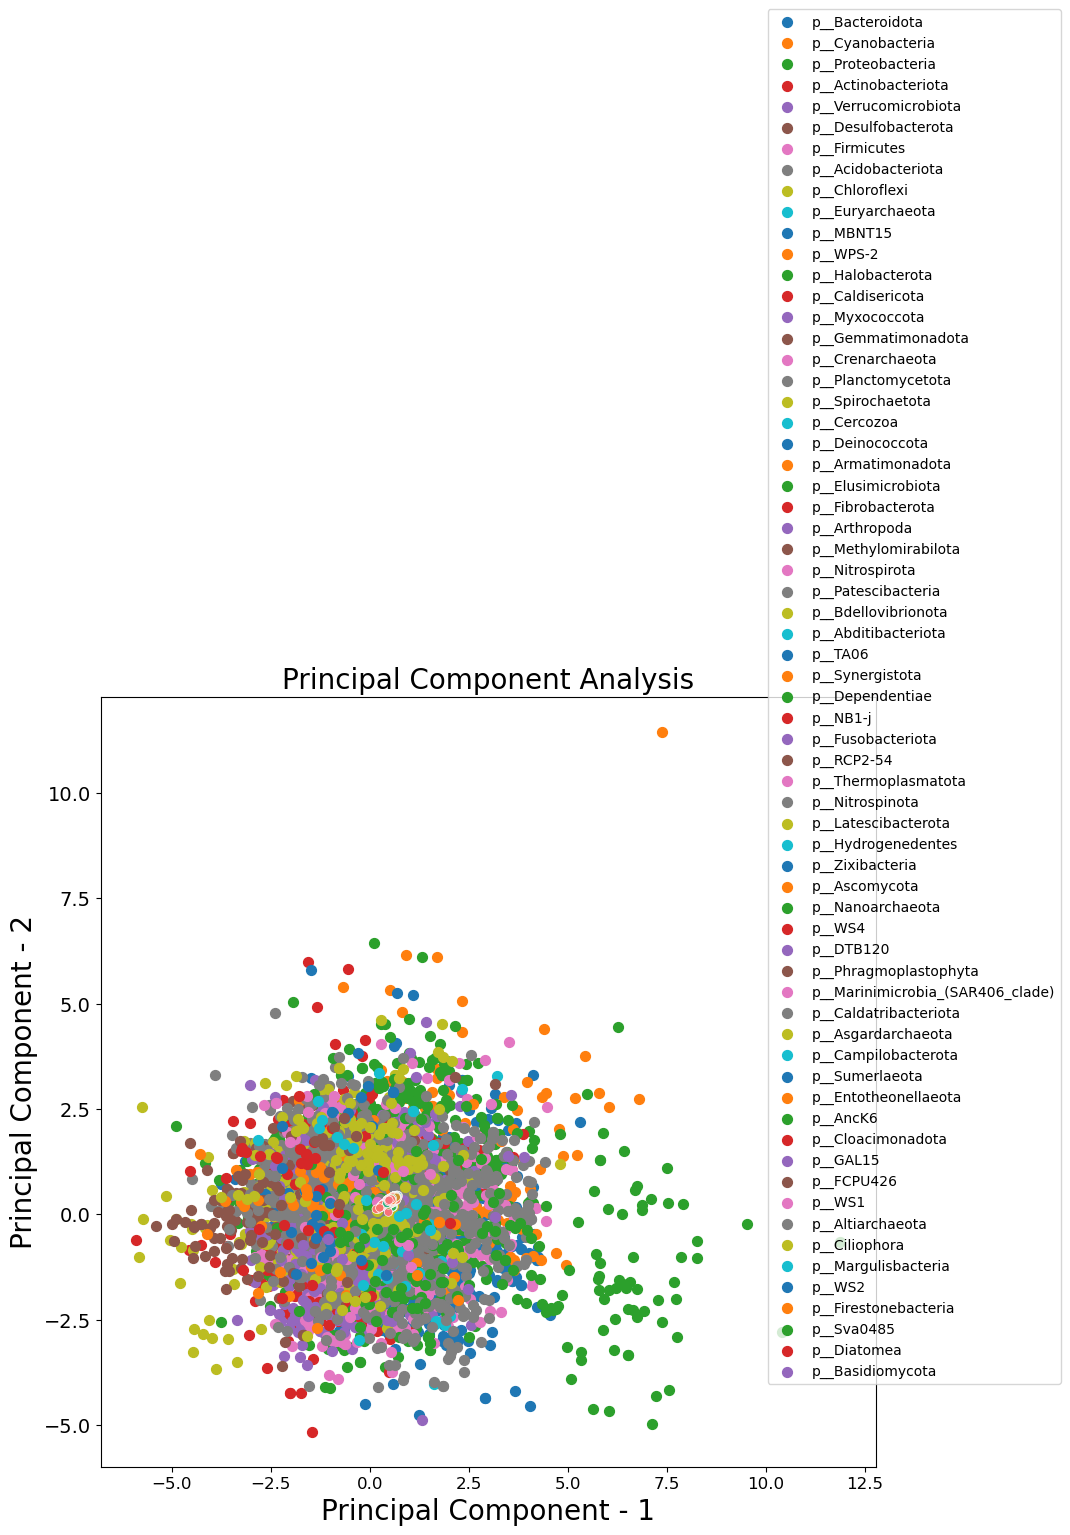

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
to_pca = phyla_features.drop("phylum", axis = 1)
x_standard = StandardScaler().fit_transform(to_pca)
feat_cols = ['feature'+str(i) for i in range(x_standard.shape[1])]
normalized = pd.DataFrame(x_standard, columns=feat_cols)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized)
pc_df = pd.DataFrame(data = principalComponents, columns = ["PC1", "PC2"])
test = np.array(phyla_features["phylum"] == "p__Proteobacteria")
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis",fontsize=20)
targets = phyla_features["phylum"].unique()
for target in targets:
    indicesToKeep = np.array(phyla_features['phylum'] == target)
    plt.scatter(pc_df.loc[indicesToKeep, 'PC1'],
            pc_df.loc[indicesToKeep, 'PC2'], s = 50)
sns.scatterplot(data = phyla_features, x = phyla_features["gc_content"], 
    y = phyla_features["relG"], hue = phyla_features["phylum"], legend = False)
plt.legend(targets, bbox_to_anchor=(1.05, 1), loc = 10)

It's a real mess, indicating that many bacterial phyla overlap in the chosen features, as is to be expected. However, the Proteobacteria (green on the right), are relatively singled out from the rest, so they should be able to be classified


## Decision tree model


X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.7676767676767676
ROC 0.6578457642049624


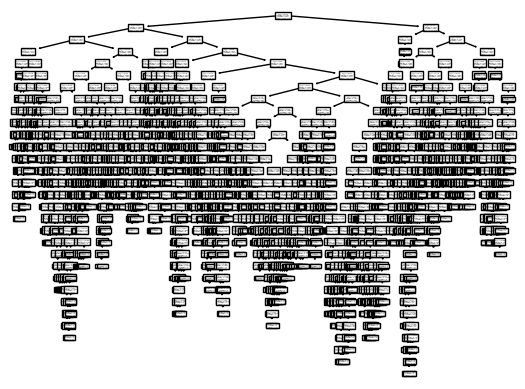

In [97]:
dummy_phyla = pd.get_dummies(phyla_features["phylum"])
y = dummy_phyla["p__Proteobacteria"]
X = pd.concat([phyla_features.drop("phylum", axis = 1)], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
dt_model = DecisionTreeClassifier(criterion = "entropy")
dt_model.fit(X_train, y_train)
_ = plot_tree(dt_model) 
prediction = dt_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'ROC {roc_auc_score(y_test, prediction)}')

The accuracy is suprisingly good, given that the features contain no information about base order. With the features I've chosen, two genes encoding completely different proteins and belonging two different taxa could be classed as identical if their base content happen to be similar.


## Random forest model

Can a random forest model do better at the same task?


In [95]:
def random_forest(X_train, y_train, X_test, y_test, depth):
    rf_model = RandomForestClassifier(n_estimators=100, 
        criterion = "gini", max_depth = depth)
    rf_model.fit(X_train, y_train)
    print(f'X train shape: {X_train.shape}')
    print(f'y train shape: {y_train.shape}')
    rf_pred = rf_model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, rf_pred)}')
    print(f'ROC: {roc_auc_score(y_test, rf_pred)}')
    importance = pd.Series(rf_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)
    print("Average tree depth: ", end = '')
    print(np.mean([(estimator.tree_.max_depth) for estimator in rf_model.estimators_]))
    return importance

In [96]:
phyla_forest = random_forest(X_train, y_train, X_test, y_test, depth = None)

X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.8002244668911336
ROC: 0.6567299221847013
Average tree depth: 27.0


<BarContainer object of 6 artists>

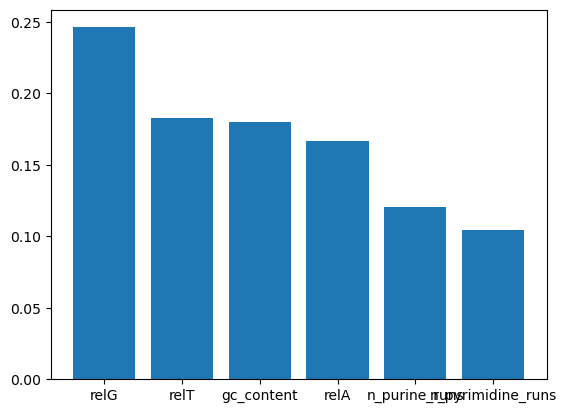

In [92]:
fig, ax = plt.subplots()
ax.bar(x = phyla_forest.index, height = phyla_forest)
# plt.xticks(range(phyla_forest.shape[1]), names, rotation=90)
# # plt.show()

As expected, the random forste and the most important feature for classification are the G content. This does make some sense, as the GC bonds are stronger than AT bonds, and confer heat resistance to a DNA molecule


#### Decreasing max depth

In [120]:
for i in range(6, 30, 6):
    phyla_forest = random_forest(X_train, y_train, X_test, y_test, depth = i)
    print("\n")

X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.7934904601571269
ROC: 0.5370228307150199
Average tree depth: 6.0


X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.8170594837261503
ROC: 0.625394582293349
Average tree depth: 12.0


X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.803030303030303
ROC: 0.6484547056232566
Average tree depth: 18.0


X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.8035914702581369
ROC: 0.6543092056966672
Average tree depth: 23.97




Clearly a depth of at least 20 is needed for a workable AUC

# Train to predict Classes

The decision tree classifier seemed reasonably good on predicting whether or not a given sequence was from Proteobacteria. Out of curiosity, will it do better at a lower taxonomic rank?


In [111]:
class_features = get_features(merged, "class", 3)
display(class_features)
dummy_classes = pd.get_dummies(class_features["class"])
y = dummy_classes["c__Cyanobacteriia"]
# The tenth most abundant class
X = pd.concat([class_features.drop("class", axis = 1)], axis = 1)
X_trainC, X_testC, y_trainC, y_testC = train_test_split(X, y, test_size=0.33, random_state=42)
class_forest = random_forest(X_trainC, y_trainC, X_testC, y_testC, depth = None)

,n_purine_runs,n_pyrimidine_runs,gc_content,class,relA,relG,relT
0,22,23,0.454545,c__Bacteroidia,0.262626,0.313131,0.282828
1,24,24,0.490000,c__Cyanobacteriia,0.300000,0.290000,0.210000
2,20,21,0.510000,c__Cyanobacteriia,0.310000,0.300000,0.180000
3,25,24,0.510000,c__Gammaproteobacteria,0.250000,0.330000,0.240000
4,26,27,0.535354,c__Gammaproteobacteria,0.252525,0.323232,0.212121
...,...,...,...,...,...,...,...
10633,22,21,0.250000,c__Alphaproteobacteria,0.390000,0.150000,0.360000
10643,25,25,0.474747,c__Cyanobacteriia,0.292929,0.303030,0.232323
10651,22,21,0.561224,c__Chlamydiae,0.265306,0.326531,0.173469
10652,23,24,0.540000,c__Gammaproteobacteria,0.260000,0.360000,0.200000


X train shape: (4607, 6)
y train shape: (4607,)
Accuracy: 0.9801762114537445
ROC: 0.5653183520599251
Average tree depth: 17.99


In [112]:
family_features = get_features(merged, "family", 5)
display(family_features)
dummy_families = pd.get_dummies(family_features["family"])
family_features["family"].value_counts()
display(family_features["family"].value_counts())
y = dummy_families["f__Comamonadaceae"]
X = family_features.drop("family", axis = 1)
X_trainF, X_testF, y_trainF, y_testF = train_test_split(X, y, test_size=0.33, random_state=42)
family_forest = random_forest(X_trainF, y_trainF, X_testF, y_testF, depth = None)


,n_purine_runs,n_pyrimidine_runs,gc_content,family,relA,relG,relT
0,22,23,0.454545,f__Bacteroidetes_vadinHA17,0.262626,0.313131,0.282828
1,24,24,0.490000,f__Leptolyngbyaceae,0.300000,0.290000,0.210000
2,20,21,0.510000,f__Chloroplast,0.310000,0.300000,0.180000
3,25,24,0.510000,f__Comamonadaceae,0.250000,0.330000,0.240000
4,26,27,0.535354,f__Comamonadaceae,0.252525,0.323232,0.212121
...,...,...,...,...,...,...,...
10627,23,22,0.530000,f__Cytophagaceae,0.240000,0.330000,0.230000
10633,22,21,0.250000,f__Mitochondria,0.390000,0.150000,0.360000
10643,25,25,0.474747,f__Nostocaceae,0.292929,0.303030,0.232323
10652,23,24,0.540000,f__Pasteurellaceae,0.260000,0.360000,0.200000


f__uncultured                     238
f__Pedosphaeraceae                164
f__Chloroplast                    118
f__Chitinophagaceae               108
f__Comamonadaceae                  93
                                 ... 
f__Cyanobiaceae                     1
f__AncK6                            1
f__Thermomicrobiaceae               1
f__Gloeobacteraceae                 1
f__Candidatus_Campbellbacteria      1
Name: family, Length: 492, dtype: int64

X train shape: (3670, 6)
y train shape: (3670,)
Accuracy: 0.9856194690265486
ROC: 0.6524956107348884
Average tree depth: 15.97


<BarContainer object of 6 artists>

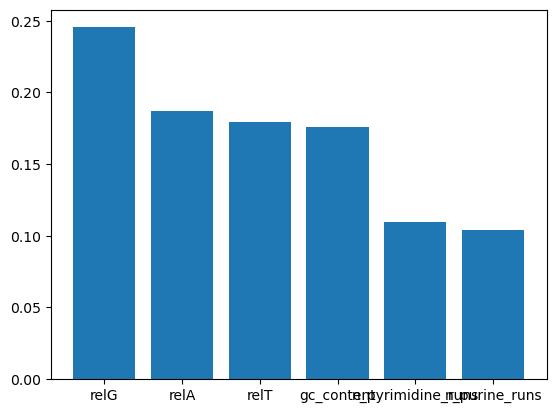

In [100]:
X_trainC
fig, ax = plt.subplots()
ax.bar(x = class_forest.index, height = class_forest)

From the accuracy scores, it seems as if the decision tree does well in distinguishing between lower ranks, but the relatively low AUC score (only 0.2 above completely random) is indicative of the model overfitting to the data. The imbalance in the data set, with some taxa being more represented than others, also makes accuracy less reliable (even though I tried to choose taxa that weren't too abundant). 

Interestingly, at lower levels individual base composition become more important features than overall gc content